# Simple moutain formation example


In [105]:
import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import fastscape
import hvplot.xarray
from xshade import hillshade
import holoviews as hv
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


## Import and inspect the model

We use the basic or sediment model available in [fastscape](https://fastscape.readthedocs.io/en/latest/).

In [106]:
sediment = True
if sediment:
    from fastscape.models import sediment_model
    model = sediment_model
else:
    from fastscape.models import basic_model
    model = basic_model

## Model setup

In [174]:
dx = 100
ny,nx = 512,512
# dx = 200
# ny,nx = 256,512
# dx = 400
# ny,nx = 256,256
ymax,xmax = dx*ny, dx*nx

dt = 2e3
tmax = 1.4e6
dt_out = 20*dt

max_Uplift = 4e-3
#Uplift = max_Uplift*np.ones((ny,nx))

Uplift = np.zeros((ny,nx))
Uplift[:,4*nx//16:12*nx//16] = max_Uplift
#Uplift[:,5*nx//16:11*nx//16] += max_Uplift

x = np.linspace(dx/2,xmax-dx/2,nx)
xx,yy = np.meshgrid(x,x)
Uplift[:,2*nx//8:3*nx//8] = max_Uplift * (xx[:,2*nx//8:3*nx//8]-xmax/4)/(xmax/8) * (0.9 + 0.2*np.random.random((ny,nx//8)))
Uplift[:,5*nx//8:6*nx//8] = max_Uplift * (3*xmax/4-xx[:,5*nx//8:6*nx//8])/(xmax/8) * (0.9 + 0.2*np.random.random((ny,nx//8)))

#Uplift[:,4*nx//16:5*nx//16] = max_Uplift * (xx[:,4*nx//16:5*nx//16]-xmax/4)/(xmax/16)
#Uplift[:,11*nx//16:12*nx//16] = max_Uplift * (3*xmax/4-xx[:,11*nx//16:12*nx//16])/(xmax/16)

# boundary = ['looped', 'looped','fixed_value','fixed_value']
# boundary = ['fixed_value','core', 'looped', 'looped']
boundary = ['fixed_value', 'fixed_value', 'looped', 'looped']

if not(sediment):
    input_vars={'grid__shape': [ny,nx],
                'grid__length': [ymax,xmax],
                'boundary__status': boundary,
                'uplift__rate': Uplift,
                'spl': {
                    'k_coef': 10e-6,
                    'area_exp': 0.5,
                    'slope_exp': 1.2},
                'diffusion__diffusivity': 1e-1}
else:
    input_vars={'grid__shape': [ny,nx],
                'grid__length': [ymax,xmax],
                'boundary__status': boundary,
                'uplift__rate': Uplift,
                'flow__slope_exp': 1.,
                'spl': {
                    'k_coef_bedrock': 1e-4,
                    'k_coef_soil': 2e-4,
                    'g_coef_bedrock': 1.,
                    'g_coef_soil': 1.,
                    'area_exp': 0.4,
                    'slope_exp': 1.},
                'diffusion': {
                    'diffusivity_bedrock': 1e-2,
                    'diffusivity_soil': 2e-2}}
    
in_ds = xs.create_setup(
    model=model,
    clocks={'time': np.arange(0, tmax + dt, dt),
            'out': np.arange(0, tmax + dt_out, dt_out),},
    master_clock='time',
    input_vars=input_vars,
    output_vars = { 'topography__elevation': 'out',
                    'terrain__slope': 'out',
                    'spl__chi': 'out',
                    'erosion__rate': 'out'})
in_ds

<xarray.Dataset>
Dimensions:                         (time: 701, out: 36, shape_yx: 2,
                                     border: 4, y: 512, x: 512)
Coordinates:
  * time                            (time) float64 0.0 2e+03 ... 1.4e+06
  * out                             (out) float64 0.0 4e+04 ... 1.36e+06 1.4e+06
Dimensions without coordinates: shape_yx, border, y, x
Data variables: (12/17)
    init_topography__seed           object None
    spl__tol_rel                    float64 0.0001
    spl__tol_abs                    float64 0.0001
    spl__max_iter                   int32 100
    grid__shape                     (shape_yx) int32 512 512
    grid__length                    (shape_yx) int32 51200 51200
    ...                              ...
    spl__g_coef_bedrock             float64 1.0
    spl__g_coef_soil                float64 1.0
    spl__area_exp                   float64 0.4
    spl__slope_exp                  float64 1.0
    diffusion__diffusivity_bedrock  float64 0.01
    diffusion__diffusivity_soil     float64 0.02

## Run the model


In [175]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model) 
# np.savez_compressed('./Result6.npz',out_ds.isel(out=-1).topography__elevation.data)

             0% | initialize 

## To continue the simulation
Didn't find how to do it

## Plot the outputs


In [ ]:
hv.extension('bokeh')
hillshade_plot = hillshade(out_ds, 'out').hvplot.image(
    x='x', y='y', cmap='gray', alpha=0.4,
    colorbar=False, hover=False, groupby='out'
)
h_limits = (0,3000)
h_plot = out_ds.topography__elevation.hvplot.image(
    x='x', y='y', cmap='terrain',clim=h_limits,groupby='out'# width=550, height=450,
)
h_profile_plot = out_ds.topography__elevation.mean('x').hvplot.line(
    ylim=h_limits, groupby='out', legend='top_left',
)

slope_limits = (0.,45.)
slope_plot = out_ds.terrain__slope.hvplot.image(
    x='x', y='y', clim=slope_limits,cmap='plasma', groupby='out'
)
slope_profile_plot = out_ds.terrain__slope.mean('x').hvplot.line(
    ylim=slope_limits,groupby='out', legend='top_left',
)

erosion_limits = (0., 2*np.max(Uplift))
erosion_plot = out_ds.erosion__rate.hvplot.image(
    x='x', y='y',clim=erosion_limits,cmap='RdYlGn_r',groupby='out'
)
erosion_profile_plot = out_ds.erosion__rate.mean('x').hvplot.line(
    ylim=erosion_limits, groupby='out', legend='top_left',
)

big_plot = ((h_plot * hillshade_plot) + h_profile_plot
          +(slope_plot * hillshade_plot) + slope_profile_plot
          +(erosion_plot * hillshade_plot) + erosion_profile_plot)
hv.Layout(big_plot).cols(2)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

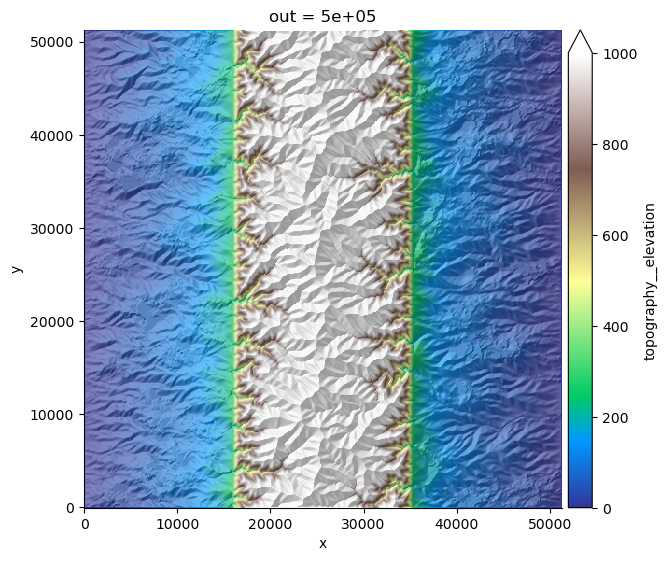

In [226]:
hillshade_plot = hillshade(out_ds.isel(out=-8)).hvplot.image(
    x='x', y='y', cmap='gray', alpha=0.4,
    colorbar=False, hover=False
)
h_limits = (0,2500)
h_plot = out_ds.isel(out=-8).topography__elevation.hvplot.image(
    x='x', y='y', cmap='terrain',clim=h_limits,width=nx, height=ny
)

hv.extension('matplotlib')
hv.render(h_plot * hillshade_plot)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

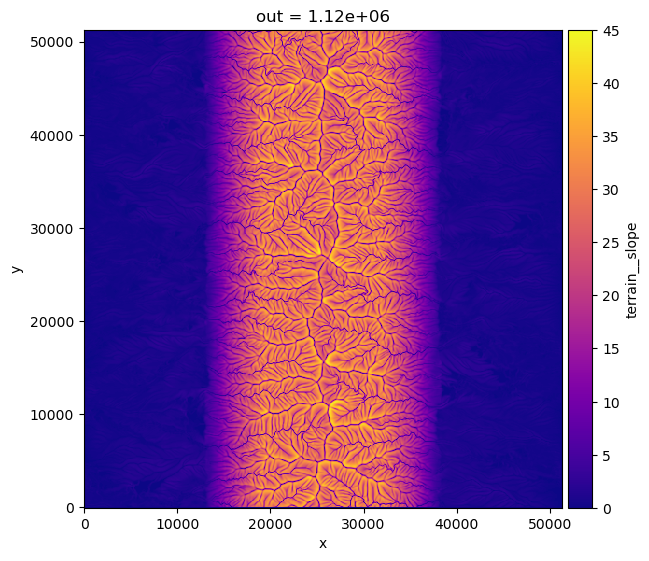

In [219]:
slope_limits = (0.,45.)
h_slope = out_ds.isel(out=-8).terrain__slope.hvplot.image(
    x='x', y='y', clim=slope_limits,cmap='plasma',width=nx, height=ny
)
hv.extension('matplotlib')
hv.render(h_slope)

In [231]:
print(out_ds.terrain__slope.max(('x','y'))[-8])
print(out_ds.terrain__slope.max(('x','y')))
print(out_ds.topography__elevation.max(('x','y'))[-8])
print(out_ds.topography__elevation.max(('x','y')))

<xarray.DataArray 'terrain__slope' ()>
array(44.52044891)
Coordinates:
    out      float64 1.12e+06
<xarray.DataArray 'terrain__slope' (out: 36)>
array([ 0.28531432, 12.27888652, 24.20930494, 28.5515999 , 31.85963273,
       29.34670001, 31.31424878, 30.37956043, 44.62354264, 39.23014626,
       42.31836781, 36.76562279, 37.69768136, 38.56858984, 37.84191336,
       38.2080022 , 40.00985913, 44.61520393, 45.85377204, 42.22763133,
       41.1788231 , 41.31718259, 42.26037869, 42.20699793, 44.94895962,
       45.18101186, 46.0530068 , 44.95192816, 44.52044891, 44.72772891,
       45.06937031, 45.42832777, 45.52213101, 46.29939075, 46.67115399,
       46.41041373])
Coordinates:
  * out      (out) float64 0.0 4e+04 8e+04 1.2e+05 ... 1.32e+06 1.36e+06 1.4e+06
<xarray.DataArray 'topography__elevation' ()>
array(2438.95848434)
Coordinates:
    out      float64 1.12e+06
<xarray.DataArray 'topography__elevation' (out: 36)>
array([9.99992712e-01, 1.60579544e+02, 3.20493286e+02, 4.80464071e+02,


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

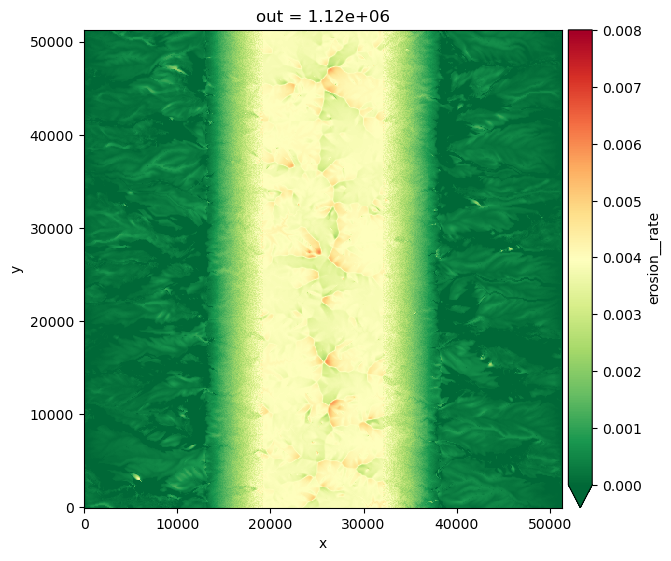

In [223]:
erosion_limits = (0., 8e-3)
erosion_plot = out_ds.isel(out=-8).erosion__rate.hvplot.image(
    x='x', y='y',clim=erosion_limits,cmap='RdYlGn_r',width=nx, height=ny
)
hv.extension('matplotlib')
hv.render(erosion_plot)

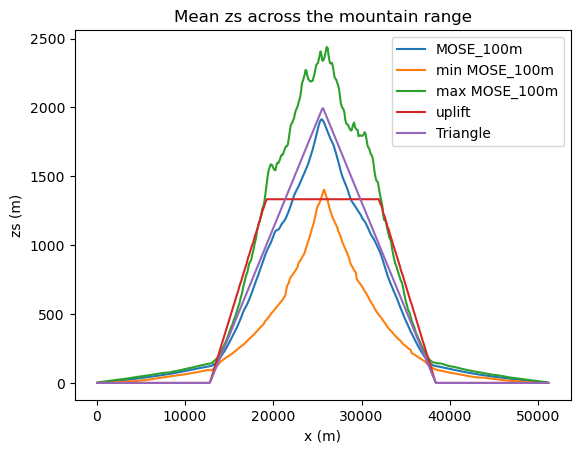

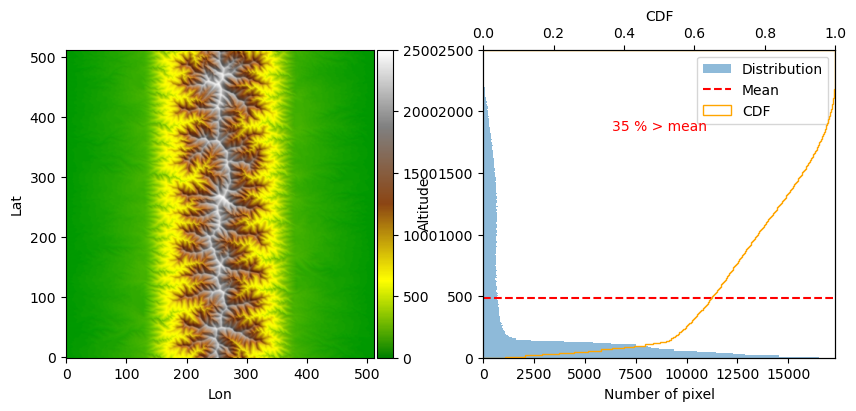

In [233]:
%matplotlib inline
plt.figure()
zs = np.array(out_ds.isel(out=-8).topography__elevation)
plt.plot(x,np.mean(zs,axis=0), label="MOSE_100m")
plt.plot(x,np.min(zs,axis=0), label="min MOSE_100m")
plt.plot(x,np.max(zs,axis=0), label="max MOSE_100m")
plt.plot(x,np.mean(Uplift,axis=0)*1e6/3, label="uplift")
plt.plot(x,np.maximum(0.,2e3*(1-np.abs(x-xmax/2)/(xmax/4))), label="Triangle")
plt.legend()
plt.title("Mean zs across the mountain range")
plt.xlabel("x (m)")
plt.ylabel("zs (m)")
plt.show()
from matplotlib.colors import LightSource
import matplotlib
hcm = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","saddlebrown","grey","w"])
def show_H_stats(Hc,dx,extent=None,shading=False,Hmax=2500):
    fig, ax = plt.subplots(ncols=2,figsize=(10,4))
    Hcmax = Hmax#np.max(Hc)
    im = ax[0].imshow(Hc, cmap=hcm,vmin=0,vmax=Hcmax, origin='lower',interpolation='none',visible=not(shading))
    if shading:
        ls = LightSource(325, 45)
        rgb = ls.shade(Hc, cmap=hcm,vmin=0,vmax=Hcmax, vert_exag=Hcmax/Hmax/dx, blend_mode='soft')
        ax[0].imshow(rgb, origin='lower',extent=extent,interpolation='bilinear')
    plt.colorbar(im,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend=None)
    ax[0].set_xlabel("Lon")
    ax[0].set_ylabel("Lat")
    
    z_bins = np.linspace(0.,1.0001,257)*Hmax
    
    ax[1].hist(Hc.flatten(),bins=z_bins[:],density=False, orientation="horizontal",alpha=0.5,label="Distribution")
    ax[1].set_ylim([0,Hcmax])
#     ax[1].set_yticks([])
    ax[1].set_xlabel("Number of pixel")
    ax[1].set_ylabel("Altitude")
    
    ax_cum = ax[1].twiny()
    ax_cum.hist(Hc.flatten(),bins=z_bins[:], density=True, histtype="step",color='orange', orientation="horizontal",
                cumulative=True, label="CDF")
    ax_cum.set_xlim([0,1])
    Hc_mean = np.mean(Hc)
    above_mean_ratio = np.mean(Hc>Hc_mean)
    ax[1].axhline(np.mean(Hc),color='r',linestyle='--',label='Mean')
    ax_cum.text(1/2,Hcmax*3/4,str(round(above_mean_ratio*100))+' % > mean',color='r',ha='center', va='center')
    ax_cum.set_xlabel("CDF")
    lines, labels = ax[1].get_legend_handles_labels() ; lines2, labels2 = ax_cum.get_legend_handles_labels()
    ax[1].legend(lines + lines2, labels + labels2, loc=0)
    plt.show()
    
show_H_stats(zs,dx,shading=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

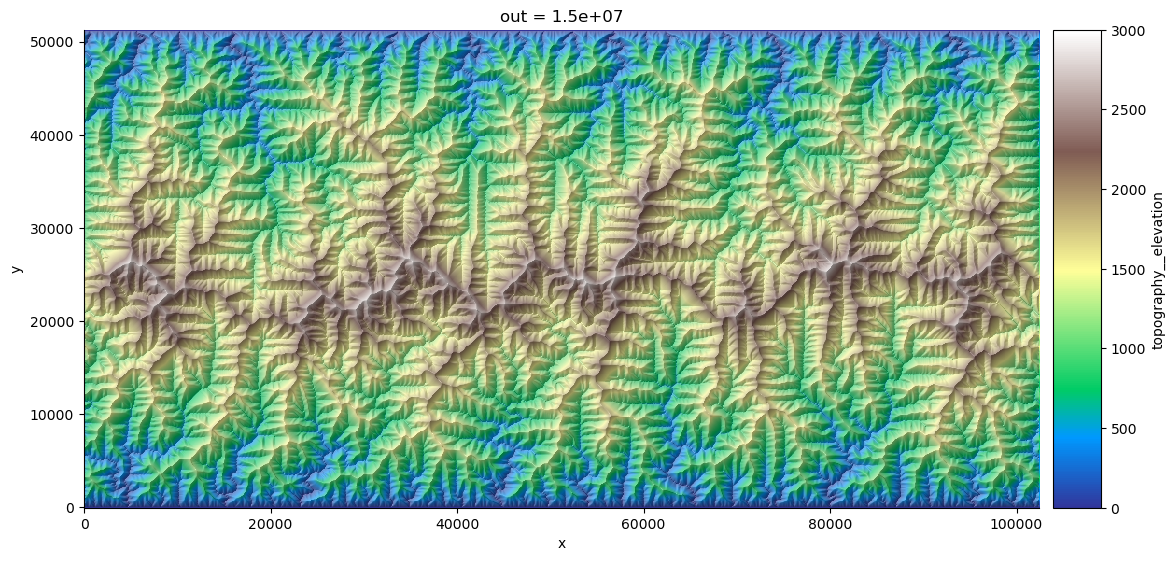

In [27]:
hillshade_plot = hillshade(out_ds.isel(out=-1)).hvplot.image(
    x='x', y='y', cmap='gray', alpha=0.4,
    colorbar=False, hover=False
)
h_limits = (0,3000)
h_plot = out_ds.isel(out=-1).topography__elevation.hvplot.image(
    x='x', y='y', cmap='terrain',clim=h_limits,width=nx, height=ny
)
hv.extension('matplotlib')
hv.render(h_plot * hillshade_plot)

## Set mean zs to 500m

In [5]:
# zs200 = np.load('./Result2.npz')['arr_0']
# zs200[:,:128] = 0.
# zs200[:,256+128:] = 0.
zs100 = np.zeros((1024,1024))
zs100[:,256:3*256] = np.transpose(np.load('./Result6.npz')['arr_0'])

In [6]:
np.mean(zs100)

610.3987734818379

In [7]:
zs100*=500/np.mean(zs100)

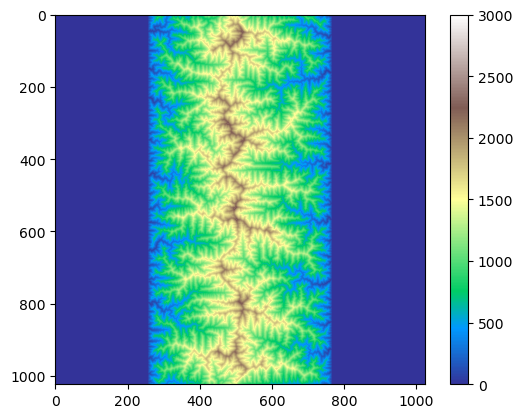

In [8]:
plt.imshow(zs100,cmap='terrain',vmax=3000)
plt.colorbar()

## Up/down scaling

In [9]:
from numba import njit
from numpy.lib.stride_tricks import as_strided
@njit
def g(x,y):
    return (x-y)/2
@njit
def f(a,b,c):
    x=(a-b)/max(a,b)
    y=(c-b)/max(c,b)
    return g(x,y)/2
@njit
def downscale2D(d,isot=0.4):
    ny,nx= d.shape
    d2=np.zeros((2*ny,2*nx))
    for j in range(ny):
        for i in range(nx):
            b=d[j,i]
            if b>0:
                a=isot*d[j-1,i] + (1-isot)/2*(d[j-1,i-1]+d[j-1,(i+1)%nx])
                c=isot*d[(j+1)%ny,i] + (1-isot)/2*(d[(j+1)%ny,i-1]+d[(j+1)%ny,(i+1)%nx])
                fy=f(a,b,c)
                a=isot*d[j,i-1] + (1-isot)/2*(d[j-1,i-1]+d[(j+1)%ny,i-1])
                c=isot*d[j,(i+1)%nx] + (1-isot)/2*(d[j-1,(i+1)%nx]+d[(j+1)%ny,(i+1)%nx])
                fx=f(a,b,c)
                d2[2*j,2*i]=(1+fy)*(1+fx)*b
                d2[2*j+1,2*i]=(1-fy)*(1+fx)*b
                d2[2*j,2*i+1]=(1+fy)*(1-fx)*b
                d2[2*j+1,2*i+1]=(1-fy)*(1-fx)*b
    return d2
def regrid_mean(a,n):
    return as_strided(a, shape= tuple(map(lambda x: int(x / n), a.shape)) + (n, n), strides=tuple(map(lambda x: x*n, a.strides)) + a.strides).mean(axis=(2,3))

In [10]:
zs200 = regrid_mean(zs100,2)
zs400 = regrid_mean(zs100,4)
zs800 = regrid_mean(zs100,8)

In [11]:
print("  dx    Mean_zs    Max_zs    Mean_slope    Max_slope  ")
for i,zs in enumerate([zs100,zs200,zs400,zs800]):
    print(100*2**i,np.mean(zs),np.max(zs),
          (np.mean(np.abs(zs[1:,:]-zs[:-1,:]))+np.mean(np.abs(zs[:,1:]-zs[:,:-1])))/2/ (100*2**i),
          max(np.max(np.abs(zs[1:,:]-zs[:-1,:])),np.max(np.abs(zs[:,1:]-zs[:,:-1]))) / (100*2**i) )
          

  dx    Mean_zs    Max_zs    Mean_slope    Max_slope  
100 499.9999999999998 2329.38808940547 0.15413855902099496 1.3844092704713922
200 499.9999999999997 2326.0022316367495 0.13504856233782683 0.9326749782786998
400 499.99999999999983 2293.567717984957 0.1091629388444888 0.6773420816820243
800 499.9999999999999 2212.3167699759388 0.07659392592814926 0.48994130820535386


1345.2427521024856
1345.2427521024854
1345.2427521024856
1345.2427521024856


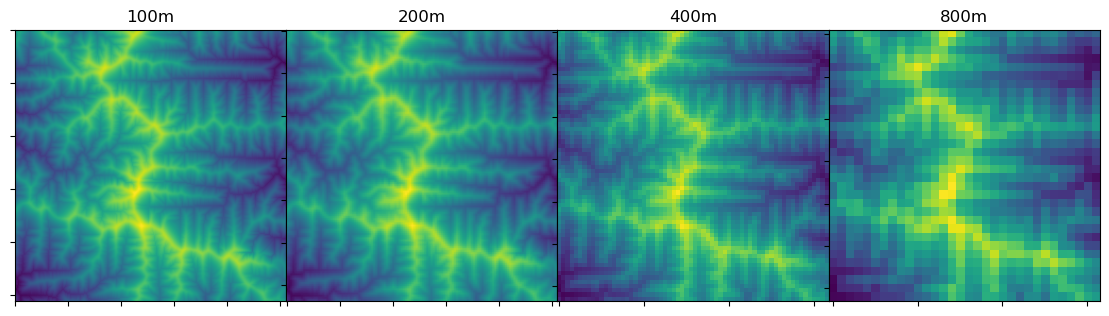

In [16]:
fig,axes = plt.subplots(ncols=4,nrows=1, figsize=(14,4),gridspec_kw = {'wspace':0, 'hspace':0})
for a in axes:
    a.set_xticklabels([]) ;a.set_yticklabels([]) ; a.set_aspect('equal')
for i,zs in enumerate([zs100,zs200,zs400,zs800]):
    q = 3*16*2**(3-i)
    axes[i].imshow(zs[q:-q,q:-q]) ; axes[i].set_title(["100m","200m","400m","800m"][i])
    print( np.mean(zs[q:-q,q:-q]) )
plt.show()

Text(0, 0.5, 'zs (m)')

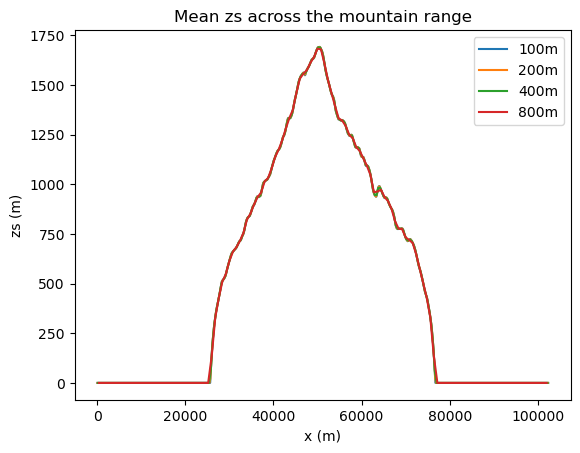

In [17]:
plt.figure()
for i,zs in enumerate([zs100,zs200,zs400,zs800]):
    dxi = dx*2**i
    plt.plot(np.linspace(dxi/2,xmax-dxi/2,nx//(2**i)),np.mean(zs,axis=0), label=["100m","200m","400m","800m"][i])
plt.legend()
plt.title("Mean zs across the mountain range")
plt.xlabel("x (m)")
plt.ylabel("zs (m)")

## MNH Free format printing

In [18]:
def save_txt_ZSDATA(zs,name):
    ny,nx = zs.shape
    with open('ZSDATA_'+name+'.txt','w') as f:
        f.write('ZSDATA\n')
        for j in range(ny):
            for i in range(nx):
                f.write("{:.1f} ".format(zs[j,i]))
            f.write('\n')

save_txt_ZSDATA(zs100,'MOPL100')
save_txt_ZSDATA(zs200,'MOPL200')
save_txt_ZSDATA(zs400,'MOPL400')
save_txt_ZSDATA(zs800,'MOPL800')

In [14]:
np.save('MOPL_B100m',zs100) # B = big (1048x1048)
np.save('MOPL_M200m',zs200) # M = medium (512x512)
np.save('MOPL_S400m',zs400) # S = small (256x256)
np.save('MOPL_T800m',zs800) # T = tiny (128x128)

488.1778415865178 2438.958484336766
1.0242169090982534
499.99999999999983 2498.0225202463635


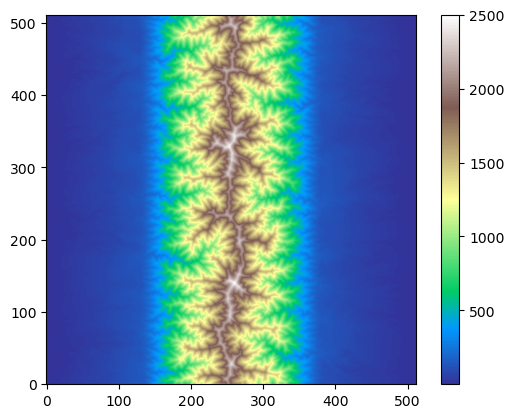

In [243]:
zs = np.array(out_ds.isel(out=-8).topography__elevation)
print(np.mean(zs),np.max(zs))
print(500/np.mean(zs))
zs /= np.mean(zs)/500
zs = np.roll(zs,-ny//4,axis=0)
plt.imshow(zs,cmap='terrain',vmax=2500,origin='lower')
plt.colorbar()
print(np.mean(zs),np.max(zs))
np.save('MOPL_M100m',zs) # M = medium (512x512)